In [1]:
%matplotlib inline
import numpy as np

In [2]:
! pip install pydicom==1.2.0

## CT, SOFT TISSUE NECK


# Data exploratory:


This example illustrates how to open a DICOM file, print some dataset
information, and show it using matplotlib.


In [3]:
%matplotlib inline

import numpy as np
import pydicom
import os
import matplotlib.pyplot as plt
from glob import glob
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import scipy.ndimage
from skimage import morphology
from skimage import measure
from skimage.transform import resize
from sklearn.cluster import KMeans
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly.tools import FigureFactory as FF
from plotly.graph_objs import *
init_notebook_mode(connected=True)

In [4]:
#data_path = "C:/Users/lykha/OneDrive/Documents/Medical-imaging-Research/Data/HNSCC/HNSCC-01-0217/12-16-2012-002-95635/2.000000-ORALNASOPHARYNX-83562"
data_path = "C:/Users/lykha/OneDrive/Documents/Medical-imaging-Research/Data/HNSCC/HNSCC-01-0001/12-05-1998-RT SIMULATION-43582/28768/"
output_path = "C:/Users/lykha/OneDrive/Documents/Medical-imaging-Research/Sample_data/"
g = glob(data_path + '/*.dcm')

# Print out the first 5 file names to verify we're in the right folder.
print ("Total of %d DICOM images./nFirst 5 filenames:" % len(g))
print('/n'.join(g[:5]))

Total of 8 DICOM images./nFirst 5 filenames:
C:/Users/lykha/OneDrive/Documents/Medical-imaging-Research/Data/HNSCC/HNSCC-01-0001/12-05-1998-RT SIMULATION-43582/28768\1-001.dcm/nC:/Users/lykha/OneDrive/Documents/Medical-imaging-Research/Data/HNSCC/HNSCC-01-0001/12-05-1998-RT SIMULATION-43582/28768\1-002.dcm/nC:/Users/lykha/OneDrive/Documents/Medical-imaging-Research/Data/HNSCC/HNSCC-01-0001/12-05-1998-RT SIMULATION-43582/28768\1-003.dcm/nC:/Users/lykha/OneDrive/Documents/Medical-imaging-Research/Data/HNSCC/HNSCC-01-0001/12-05-1998-RT SIMULATION-43582/28768\1-004.dcm/nC:/Users/lykha/OneDrive/Documents/Medical-imaging-Research/Data/HNSCC/HNSCC-01-0001/12-05-1998-RT SIMULATION-43582/28768\1-005.dcm


In [5]:
#      
# Loop over the image files and store everything into a list.
# 

def load_scan(path):
    slices = [pydicom.read_file(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key = lambda x: int(x.InstanceNumber))
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
        
    for s in slices:
        s.SliceThickness = slice_thickness
        
    return slices

def get_pixels_hu(scans):
    image = np.stack([s.pixel_array for s in scans])
    # Convert to int16 (from sometimes int16), 
    # should be possible as values should always be low enough (<32k)
    image = image.astype(np.int16)
    print(type(image))
    print(image.shape)
    # Set outside-of-scan pixels to 1
    # The intercept is usually -1024, so air is approximately 0
    image[image == -2000] = 0
    
    # Convert to Hounsfield units (HU)
    intercept = scans[0].RescaleIntercept
    slope = scans[0].RescaleSlope
    
    if slope != 1:
        image = slope * image.astype(np.float64)
        image = image.astype(np.int16)
        
    image += np.int16(intercept)
    
    return np.array(image, dtype=np.int16)

id=0
patient = load_scan(data_path)
imgs = get_pixels_hu(patient)

<class 'numpy.ndarray'>
(8, 512, 512)


**The dataset has 8 slices and each slice has dim of 512x512**

In [9]:
print("Slice Thickness: %f" % patient[0].SliceThickness)
print("Pixel Spacing (row, col): (%f, %f) " % (patient[0].PixelSpacing[0], patient[0].PixelSpacing[1]))

Slice Thickness: 2.500000
Pixel Spacing (row, col): (0.937500, 0.937500) 


**Voxel size: (0.94 x 0.94 x 2.5)**

In [6]:
np.save(output_path + "fullimages_%d.npy" % (id), imgs)

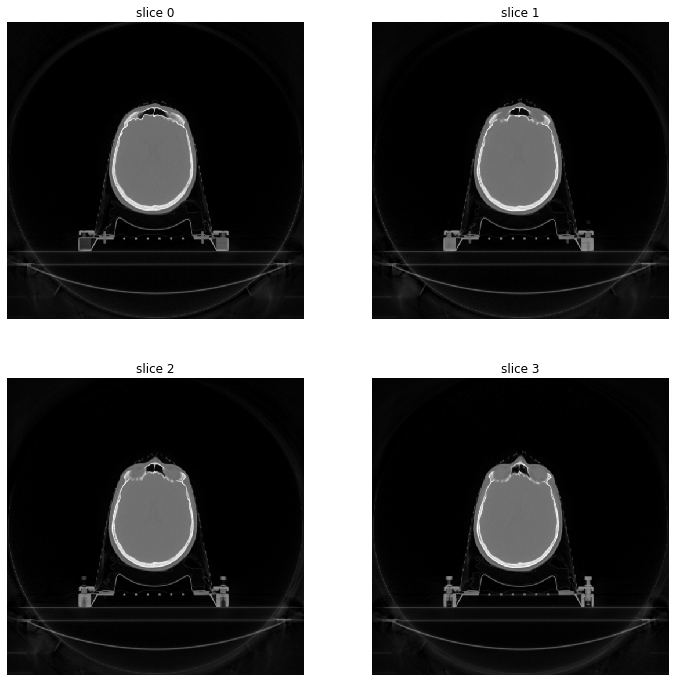

In [8]:
id = 0
imgs_to_process = np.load(output_path+'fullimages_{}.npy'.format(id))

def sample_stack(stack, rows=2, cols=2, start_with=0, show_every=1):
    fig,ax = plt.subplots(rows,cols,figsize=[12,12])
    for i in range(rows*cols):
        ind = start_with + i*show_every
        ax[int(i/rows),int(i % rows)].set_title('slice %d' % ind)
        ax[int(i/rows),int(i % rows)].imshow(stack[ind],cmap='gray')
        ax[int(i/rows),int(i % rows)].axis('off')
    plt.show()

sample_stack(imgs_to_process)

## Implementation of the algorithm

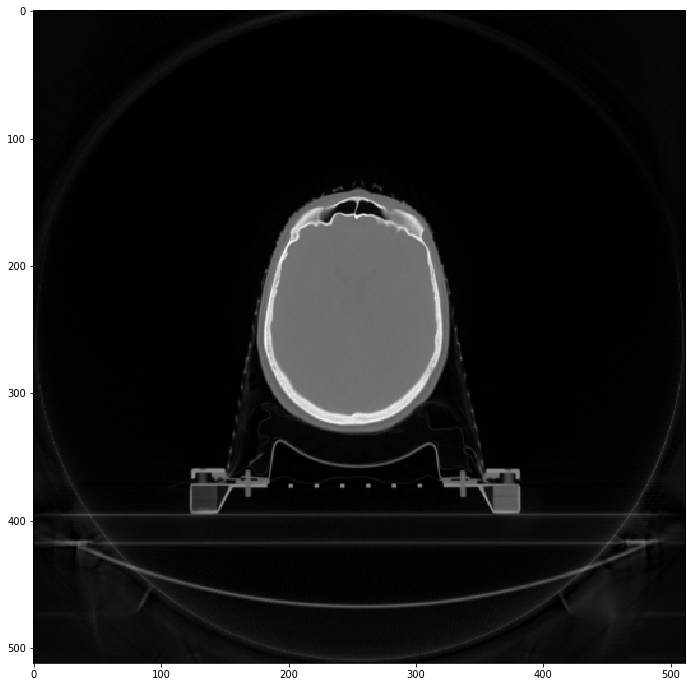

In [10]:
imgs_to_process = np.load(output_path+'fullimages_{}.npy'.format(id))
fig,ax = plt.subplots(1,1,figsize=[12,12])
ax.imshow(imgs_to_process[0], cmap="gray")
plt.show()

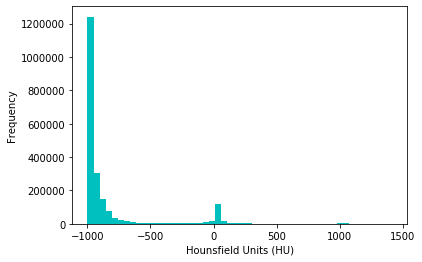

In [7]:
file_used=output_path+"fullimages_%d.npy" % id
imgs_to_process = np.load(file_used).astype(np.float64) 

plt.hist(imgs_to_process.flatten(), bins=50, color='c')
plt.xlabel("Hounsfield Units (HU)")
plt.ylabel("Frequency")
plt.show()

-There is lots of air (-1000 HU)

-There's an some of soft tissue, mostly muscle, and some fat (-100 to 60) 

-There is only a small bit of bone (700-3000)

## |(Fct)i,k| = invnorm(prand, 0, SD)

In [11]:
from scipy.stats import uniform, norm
import scipy.stats as sct

img = imgs_to_process[0]
mask = np.ndarray([512, 512],dtype=np.float64)
mask[:] = 0
Fsd_mat = np.ndarray([512, 512],dtype=np.float64)
Fsd_mat[:] = 0
Fct_mat = np.ndarray([512, 512],dtype=np.float64)
Fct_mat[:] = 0
for i in range(0,512-1):        
    for r in range(0, 512-1):
        prand = uniform.rvs(0, 1, size = 1)  
        Fsd_x = sct.norm.cdf(prand, loc = 0, scale = 1.7)
        Fsd_y = sct.norm.cdf(prand, loc = 0, scale = 2)
        Fsd_z = sct.norm.cdf(prand, loc = 0, scale = 3)
        Fsd = np.array([Fsd_x, Fsd_y, Fsd_z])
        
        voxelsize = np.array([0.937500, 0.937500, 2.5])
        gradct = (img[r+1,i]-img[r-1, i])/(2*voxelsize)
        a = 50
        #Fsd = 1
        Fct_r = a/(np.abs(gradct)+a)
        Fct_x =  Fct_r[0]
        Fct_y =  Fct_r[1]
        Fct_z =  Fct_r[2]
        
        D_x = Fsd_x*Fct_x
        D_y = Fsd_y*Fct_y
        D_z = Fsd_z*Fct_z
        D_r = np.array([D_x, D_y, D_z])
        D = np.linalg.norm(D_r) #magnitude of a vector D
        mask[r, i] = D
    

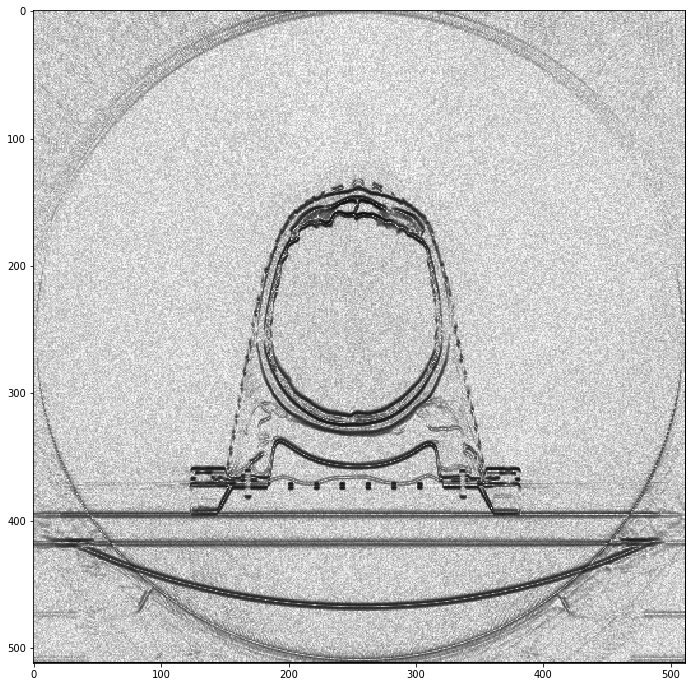

In [12]:
fig,ax = plt.subplots(1,1,figsize=[12,12])
ax.imshow(mask, cmap="gray")
plt.show()

In [13]:
from scipy.stats import uniform, norm
import scipy.stats as sct
import numpy as np
def ASSD(img):
    size = img.shape
    mask = np.ndarray([size[0], size[1]],dtype=np.float64)
    mask[:] = 0
    X = np.empty(1, dtype=np.float64)
    Y = np.empty(1, dtype=np.float64)
        
    for i in range(0,size[0]-1):        
        for r in range(0, size[1]-1):
            prand = uniform.rvs(0, 1, size = 1)  
            Fsd_x = sct.norm.cdf(prand, loc = 0, scale = 1.7)
            Fsd_y = sct.norm.cdf(prand, loc = 0, scale = 2)
            Fsd_z = sct.norm.cdf(prand, loc = 0, scale = 3)
            Fsd = np.array([Fsd_x, Fsd_y, Fsd_z])
        
            voxelsize = np.array([0.488281, 0.488281, 1])
            gradct = (img[r+1,i]-img[r-1, i])/(2*voxelsize)
            a = 50
            #Fsd = 1
            Fct_r = a/(np.abs(gradct)+a)
            Fct_x =  Fct_r[0]
            Fct_y =  Fct_r[1]
            Fct_z =  Fct_r[2]
        
            D_x = Fsd_x*Fct_x
            D_y = Fsd_y*Fct_y
            D_z = Fsd_z*Fct_z
            D_r = np.array([D_x, D_y, D_z])
            D = np.linalg.norm(D_r) #magnitude of a vector D
            mask[r, i] = D
    return mask

masked_lung = []

for img in imgs_to_process:
    masked_lung.append(ASSD(img))

sample_stack(masked_lung, show_every=3)

In [14]:
#Standardize the pixel values
def make_lungmask(img, display=False):
    row_size= img.shape[0]
    col_size = img.shape[1]
    
    mean = np.mean(img)
    std = np.std(img)
    img = img-mean
    img = img/std
    # Find the average pixel value near the lungs
    # to renormalize washed out images
    middle = img[int(col_size/5):int(col_size/5*4),int(row_size/5):int(row_size/5*4)]   
    mean = np.mean(middle)  
    max = np.max(img)
    min = np.min(img)
    # To improve threshold finding, I'm moving the 
    # underflow and overflow on the pixel spectrum
    img[img==max]=mean
    img[img==min]=mean
    
    # Using ASSD to separate foreground (soft tissue) and background (air)
    #
    means = ASSD(middle)
    centers = sorted(means.flatten())
    threshold = np.mean(centers)
    thresh_img = np.where(img<threshold,1.0,0.0)  # threshold the image

    # First erode away the finer elements, then dilate to include some of the pixels surrounding the soft tissue.  
    # We don't want to accidentally clip the lung.

    eroded = morphology.erosion(thresh_img,np.ones([3,3]))
    dilation = morphology.dilation(eroded,np.ones([8,8]))

    labels = measure.label(dilation) # Different labels are displayed in different colors
    label_vals = np.unique(labels)
    regions = measure.regionprops(labels)
    good_labels = []
    for prop in regions:
        B = prop.bbox
        #if B[2]-B[0]<row_size/10*9 and B[3]-B[1]<col_size/10*9 and B[0]>row_size/5 and B[2]<col_size/5*4:
        good_labels.append(prop.label)
    mask = np.ndarray([row_size,col_size],dtype=np.int8)
    mask[:] = 0
    #
    #  After just the lungs are left, we do another large dilation
    #  in order to fill in and out the lung mask 
    #
    for N in good_labels:
        mask = mask + np.where(labels==N,1,0)
    mask = morphology.dilation(mask,np.ones([10,10])) # one last dilation
    if (display):
        fig, ax = plt.subplots(3, 2, figsize=[12, 12])
        ax[0, 0].set_title("Original")
        ax[0, 0].imshow(img, cmap='gray')
        ax[0, 0].axis('off')
        ax[0, 1].set_title("Threshold")
        ax[0, 1].imshow(thresh_img, cmap='gray')
        ax[0, 1].axis('off')
        ax[1, 0].set_title("After Erosion and Dilation")
        ax[1, 0].imshow(dilation, cmap='gray')
        ax[1, 0].axis('off')
        ax[1, 1].set_title("Color Labels")
        ax[1, 1].imshow(labels)
        ax[1, 1].axis('off', cmap='gray')
        ax[2, 0].set_title("Final Mask")
        ax[2, 0].imshow(mask, cmap='gray')
        ax[2, 0].axis('off')
        ax[2, 1].set_title("Apply Mask on Original")
        ax[2, 1].imshow(mask*img)
        ax[2, 1].axis('off')
        
        plt.show()
    return mask*img

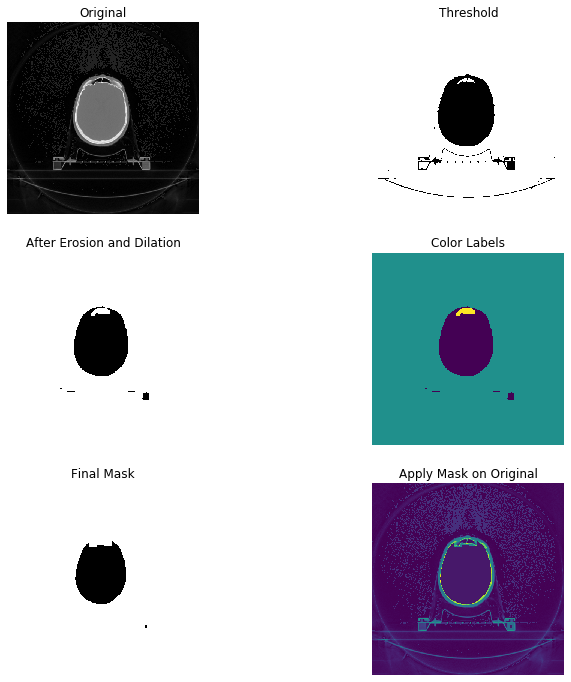

array([[ 0.50489346, -0.29672788, -0.2758684 , ..., -0.30268774,
        -0.32652715, -0.34142678],
       [-0.29672788, -0.29970781, -0.30268774, ..., -0.32652715,
        -0.27884833, -0.332487  ],
       [-0.33844685, -0.31758737, -0.30864759, ..., -0.32950707,
        -0.35036656, -0.27884833],
       ...,
       [-0.09111298, -0.10601261, -0.14773158, ..., -0.0821732 ,
        -0.04939402, -0.05237394],
       [-0.18349069, -0.18349069, -0.16263121, ..., -0.17753084,
        -0.19243047, -0.18945054],
       [-0.24308921, -0.22818958, -0.23414944, ..., -0.21626988,
        -0.21031003, -0.23414944]])

In [15]:
img = imgs_to_process[0]
make_lungmask(img, display=True)

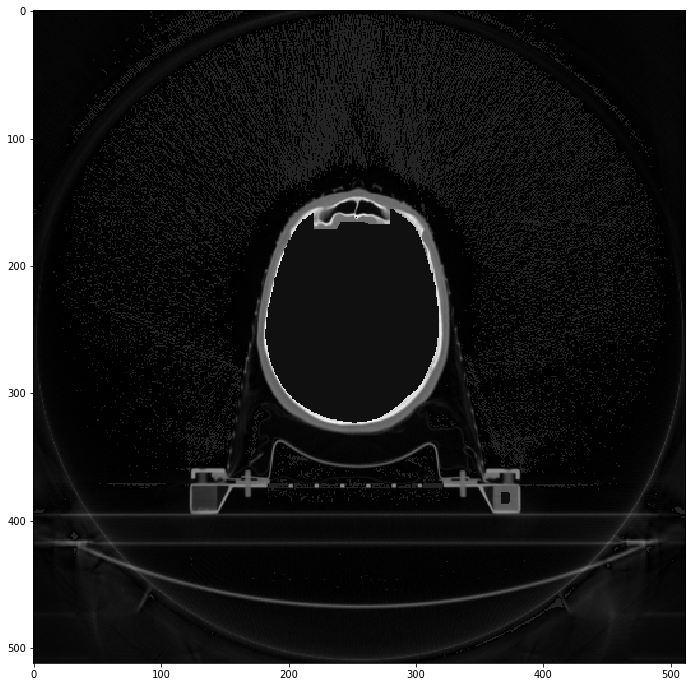

In [19]:
img = imgs_to_process[0]
mask_img = make_lungmask(img)
fig,ax = plt.subplots(1,1,figsize=[12,12])
ax.imshow(mask_img, cmap="gray")
plt.show()

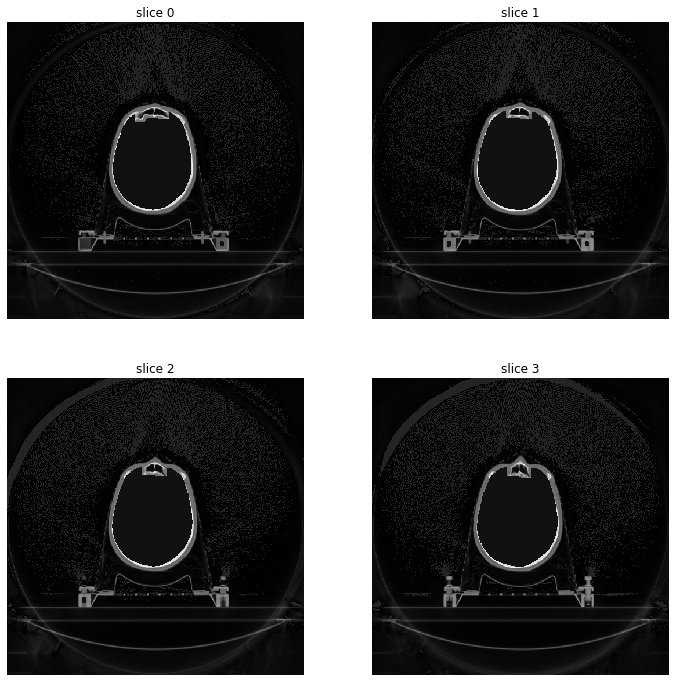

In [16]:
masked_lung = []

for img in imgs_to_process:
    masked_lung.append(make_lungmask(img))

sample_stack(masked_lung, show_every=1)